### The model

$u(c) = log(c)$ utility function    
$y = 1$ Deterministic income    
$p(r = 0.02) = 0.5$   
$p(r = -0.01) = 0.5$ 

In [1]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# discounting factor 
beta = 0.95
# wealth level
eps = 0.001
w_low = eps
w_high = 10
# interest rate
r_up = 0.02
r_down = 0.01
# deterministic income
y = 1
# good state and bad state economy with equal probability 0.5
# with good investment return 0.02 or bad investment return -0.01
ws = np.linspace(w_low, w_high**(0.5),100)**2
Vs = np.zeros(100)
Cs = np.zeros(100)

def u(c):
    return np.log(c)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Value iteration
for j in range(30):
    if j % 10 == 0:
        print(j)
    for i in range(len(ws)):
        w = ws[i]
        def obj(c):
            return -(u(c) + beta*(np.interp((y+w-c)*(1+r_up), ws, Vs) + np.interp((y+w-c)*(1-r_down), ws, Vs))/2)
        bounds = [(eps, y+w-eps)]
        res = minimize(obj, eps, method='SLSQP', bounds=bounds)
        Cs[i] = res.x[0]
        Vs[i] = -res.fun

0
10
20


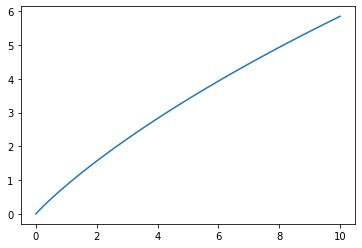

In [3]:
plt.plot(ws,Vs)

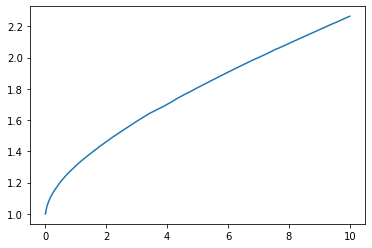

In [4]:
plt.plot(ws,Cs)

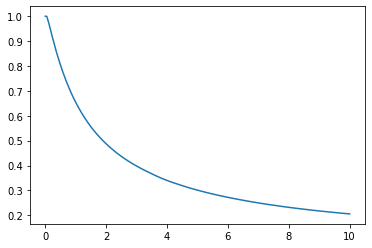

In [5]:
plt.plot(ws,Cs/(ws+y))

### policy gradient
Assume the policy form $\theta = (a,b, \sigma = 0.1)$, then $\pi_\theta$ ~ Beta($\alpha$, $\beta$)


Assume the initial value $a_1 = 0$, $b_1 = 0$, $c_1 = 0$, $d_1 = 0$, $a_2 = 0$, $b_2 = 0$, $c_2 = 0$, $d_2 = 0$:
$$\alpha = log(1+ e^{a_1 x^3 + b_1 x^2 + c_1 x + d_1}) + 1 $$
$$\beta = log(1+ e^{a_2 x^3 + b_2 x^2 + c_2 x + d_2}) + 1 $$


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [6]:
T = 100
def poly(the, w):
    return the[0]*(w**3) + the[1]*(w**2) +the[2]*w + the[3]

# simulation step T = 100
def a(theta, w):
    value = np.log(1+np.exp(poly(theta[:4],w))) + 1
    if isscalar(value):
        return max(min(value, 100),1)
    else:
        np.clip(value, 1, 100, out=value)
        return value

def b(theta, w):
    value = np.log(1+np.exp(poly(theta[4:],w))) + 1
    if isscalar(value):
        return max(min(value, 100),1)
    else:
        np.clip(value, 1, 100, out=value)
        return value


def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.uniform(w_low, w_high)
    for t in range(T):
        n = np.random.beta(a(theta, w), b(theta, w))
        n = max(min(n,1-eps),eps)
        c = n*(w+y)
        wPath[t] = w
        aPath[t] = n
        rPath[t] = u(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath

def gradientV(theta, D = 1000):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            newGrad[0] = np.sum(np.log(ap)*(wp**3)/(1+np.exp(-poly(theta[:4],wp))))
            newGrad[1] = np.sum(np.log(ap)*(wp**2)/(1+np.exp(-poly(theta[:4],wp))))
            newGrad[2] = np.sum(np.log(ap)*(wp)/(1+np.exp(-poly(theta[:4],wp))))
            newGrad[3] = np.sum(np.log(ap)*(1)/(1+np.exp(-poly(theta[:4],wp))))            
            
            newGrad[4] = np.sum(np.log(1-ap)*(wp**3)/(1+np.exp(-poly(theta[4:],wp))))
            newGrad[5] = np.sum(np.log(1-ap)*(wp**2)/(1+np.exp(-poly(theta[4:],wp))))
            newGrad[6] = np.sum(np.log(1-ap)*(wp)/(1+np.exp(-poly(theta[4:],wp))))
            newGrad[7] = np.sum(np.log(1-ap)*(1)/(1+np.exp(-poly(theta[4:],wp))))
                  
            grad += newGrad * np.sum(rp)
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta

def plot(theta):
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, a(theta,ws)/(a(theta,ws) + b(theta,ws))*(ws+y), 'r')

0
[0, 0, 0, 0, 0, 0, 0, 0]
1
[0.02869926 0.01347318 0.00890518 0.00837377 0.03348414 0.01372605
 0.00870965 0.00811706]
2
[0.03882956 0.02312129 0.01608826 0.01511039 0.0476006  0.02371187
 0.01577912 0.01463439]
3
[0.04220368 0.03092384 0.02234686 0.02100182 0.05574077 0.03200047
 0.02196282 0.02032498]
4
[0.04062981 0.03744989 0.02804136 0.02645423 0.06086894 0.03938896
 0.02768599 0.02560974]
5
[0.03608157 0.0433671  0.03336385 0.03147997 0.06412044 0.04607571
 0.03294943 0.03045763]
6
[0.02397461 0.04886512 0.03902393 0.03691462 0.06641381 0.05310856
 0.03863143 0.03570035]
7
[-0.01724472  0.04965111  0.04351491  0.04163337  0.06368376  0.05859586
  0.04352737  0.04028368]
8
[4.86863837e-01 1.48889700e-01 6.74192369e-02 5.09325529e-02
 3.70517681e+02 5.90516402e+00 1.54601682e-01 4.85475316e-02]
9
[8.90827089e-01 2.65169494e-01 1.00552222e-01 6.05912848e-02
 3.70555756e+02 5.91995397e+00 1.59171038e-01 4.98748693e-02]
10
[8.72343536e-01 2.67868451e-01 1.02853135e-01 6.17986367e-02


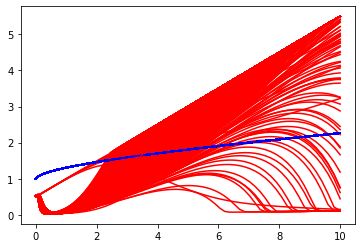

In [7]:
# initial theta
N = 1000
theta = [0]*8
# gradient ascend step size 
alpha = 0.0001
# store theta
THETA = np.zeros((len(theta),N))
for i in range(N):
    if i%1 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA[:,i] = theta
    plot(theta)

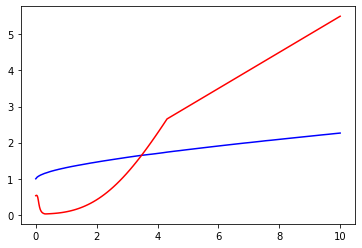

In [10]:
plot(theta)

In [9]:
# from scipy.stats import beta as B
# import matplotlib.pyplot as plt
# import numpy as np
# x = np.linspace(0, 1.0, 100)
# # for i in range(10):
# #     the = THETA[:,i]
# y = B.pdf(x, a(theta,10), b(theta,10))
# plt.plot(x, y)